# Байесовские оценки

In [6]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (15, 6)
rcParams['image.cmap'] = 'viridis'

![Задание](../img/p7_1.png)

In [154]:
from scipy.stats import norm


#1-й параметр -- сдвига, 2-ой масштаба;
param_sets_1 = [(0,1), (0,100), (10,1), (10,100)]
param_sets_2 = [(1,1), (1,100), (10,1), (10,100)]


## Модель $N(\theta,1)$

Из задачи 8.3 найденное сопряженное распределение является нормальным и имеет следующие параметры:


* Параметр сдвига (это и есть наша оценка для $\theta$):
$$\frac{<X>n\sigma^2+a}{n\sigma^2+1}$$

* Параметр масштаба (что в данном случае не так важно):
$$\frac{n\sigma^2+1}{n\sigma^2}$$

Тут априорное распределение $N(a, \sigma^2)$, где $a$ и $\sigma$ будем брать из param_sets_1

$<X>$ -- среднее значение по выборке

---


Также известно, что среднее значение выборки (или $<X>$ в данных обозначениях) -- это оценка максимального правдоподобия для нормального распределения. 

Таким образом ОМП$(\theta)=<X>$

---

In [155]:
def get_bayes_est(n, a, sigma, x_mean):
    """
    Подразумевается, что отсчет начинается с 1;
    
    """
    return (x_mean*n*(sigma**2)+a)/(n*(sigma**2)+1)

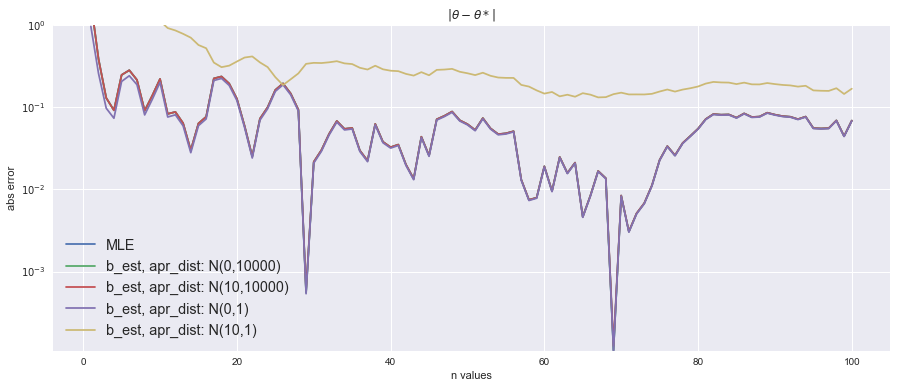

In [180]:
N = 100 # размер выборки
X = norm.rvs(loc=0, scale=1, size=N)

mle = np.array([np.mean(X[:n]) for n in range(1,N+1)]) # набор средних для каждого n;
get_name = lambda a,sigma: 'N('+str(a)+','+str(sigma**2)+')' # просто имя для каждого сета параметров;

# словарь массивов для каждого из параметров из param_sets_1
# где каждый массив -- это массив абсолютных величин разностей между нулем и байесовской оценкой для всех значений n<=100:
b_est = {get_name(a,sigma):np.array([np.abs(0-get_bayes_est(n,a,sigma,mle[n-1])) for n in range(1,N+1)]) 
         for a,sigma in param_sets_1}

x_range = range(1,N+1)
plt.plot(x_range, np.abs(mle-0), label='MLE')
for name, arr in b_est.items():
    plt.plot(x_range, arr, label="b_est, apr_dist: "+name)

plt.legend(fontsize='x-large')
plt.title(r'$|\theta-\theta*|$')
plt.xlabel("n values")
plt.ylabel("abs error")
plt.semilogy()
plt.ylim((0, 1))
plt.show()

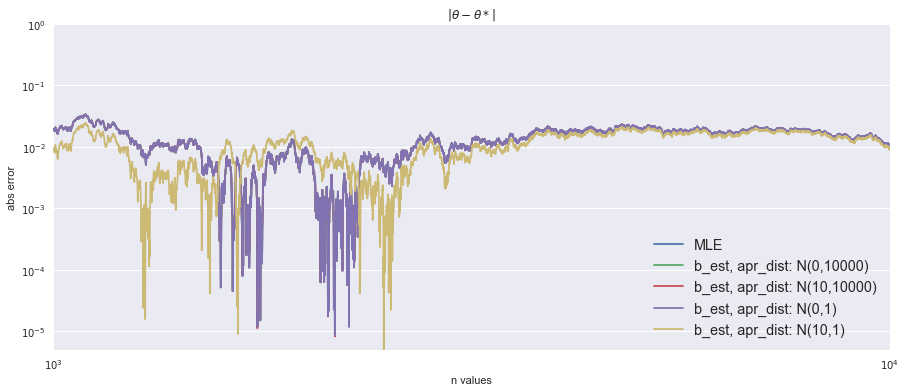

In [179]:
N = 10000 # размер выборки
X = norm.rvs(loc=0, scale=1, size=N)

mle = np.array([np.mean(X[:n]) for n in range(1,N+1)]) # набор средних для каждого n;
get_name = lambda a,sigma: 'N('+str(a)+','+str(sigma**2)+')' # просто имя для каждого сета параметров;

# словарь массивов для каждого из параметров из param_sets_1
# где каждый массив -- это массив абсолютных величин разностей между нулем и байесовской оценкой для всех значений n<=100:
b_est = {get_name(a,sigma):np.array([np.abs(0-get_bayes_est(n,a,sigma,mle[n-1])) for n in range(1,N+1)]) 
         for a,sigma in param_sets_1}

x_range = range(1,N+1)
plt.plot(x_range, np.abs(mle-0), label='MLE')
for name, arr in b_est.items():
    plt.plot(x_range, arr, label="b_est, apr_dist: "+name)

plt.legend(fontsize='x-large')
plt.title(r'$|\theta-\theta*|$')
plt.xlabel("n values")
plt.ylabel("abs error")
plt.loglog()
plt.ylim((0, 1))
plt.xlim((10**3, 10**4))
plt.show()

### Выводы:

* По первому графику кажется, что лучше всего себя показывают MLE и байесовские оценки с параметрами априорного распределения (0, 100), (10, 10000), (0,1) -- их графики почти полностью совпадают;

* Оценка с параметрами априорного распределения (0, 100) показывает худший результат в начале, но при бОльших n уже становится неочевидно кто лучше;

При каждой новой генерации выборки график несколько отличается от предыдущего, что говорит скорее о недостаточности числа N=100 для того, чтобы делать какие-то выводы.

Если построить график при N=10000, то видно, что все оценки дают примерно одинаковые ошибки при достаточно больших n.

## Модель $N(0,\theta)$

Сопряженное к $N(0,\theta)$ - Inverse-gamma Distribution: $\Gamma_{inv}(\alpha_0, \beta_0)$ 

* Его среднее $=\frac{\beta_0}{\alpha_0 - 1}$

Для получения апостериорного распределения его параметры выражаются через параметры выборочного распределения $N(0,\theta)$ так:

- $\alpha=\alpha_0 + \frac{n}{2}$

- $\beta=\beta_0 + \frac{\sum_{i=1}^n X_i^2}{2}$. 

Следовательно, т.к. байесовская оценка -- это условное матожидание по апостериорному распределению, то

$${\theta^*=\frac{\beta}{\alpha - 1} = \frac{2\beta_0 + \sum_{i=1}^n X_i^2}{2\alpha_0 + n - 2}}$$

ОМП для параметра масштаба нормального распределения это:
$$\sigma^{2*} = \frac{\sum(X_i - \mu)^2}{n} = \frac{\sum X_i^2}{n}$$
т.к $\mu$ = 0 в нашей задаче

---

In [139]:
def get_bayes_est2(n, alpha, beta, mle_val):
    """
    Подразумевается, что отсчет начинается с 1;
    
    """
#     sum_x = np.sum([x**2 for x in X[:n]])
    return (2*beta+mle_val*n)/(2*alpha+n-2)

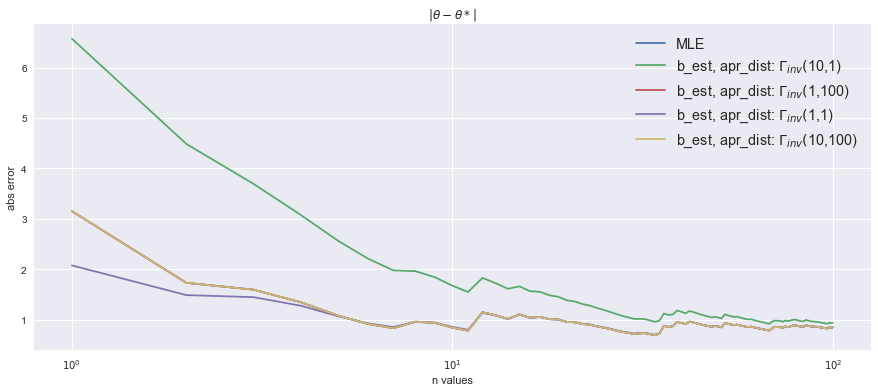

In [177]:
N = 100 # размер выборки
X = norm.rvs(loc=0, scale=1, size=N)

mle_2 = np.array([np.mean(X[:n]**2) for n in range(1,N+1)]) # ОМП для каждого n;
get_name_2 = lambda alpha,beta: r'$\Gamma_{inv}($'+str(alpha)+','+str(beta)+')' # просто имя для каждого сета параметров;

# словарь массивов для каждого из параметров из param_sets_2
# где каждый массив -- это массив абсолютных величин разностей между нулем и байесовской оценкой для всех значений n<=100:
b_est_2 = {get_name_2(alpha,beta):np.array([np.abs(0-get_bayes_est(n,alpha,beta,mle_2[n-1])) for n in range(1,N+1)]) 
         for alpha,beta in param_sets_2}

x_range = range(1,N+1)
plt.plot(x_range, np.abs(mle_2-0), label='MLE')
for name, arr in b_est_2.items():
    plt.plot(x_range, arr, label="b_est, apr_dist: "+name)

plt.legend(fontsize='x-large')
plt.title(r'$|\theta-\theta*|$')
plt.xlabel("n values")
plt.ylabel("abs error")
plt.semilogx()
plt.show()

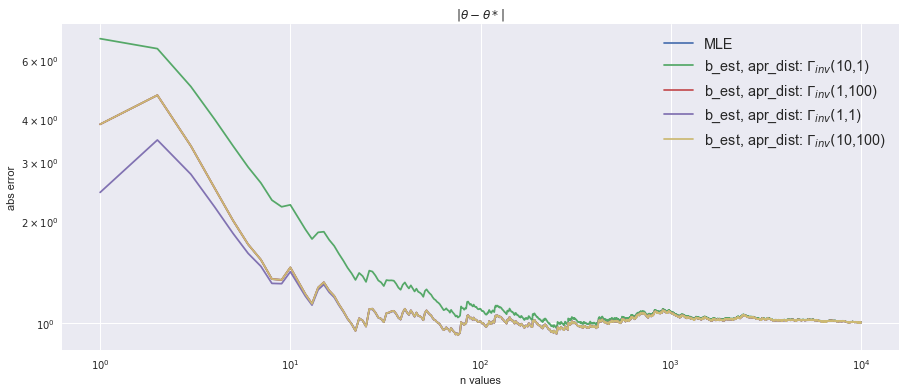

In [178]:
N = 10000 # размер выборки
X = norm.rvs(loc=0, scale=1, size=N)

mle_2 = np.array([np.mean(X[:n]**2) for n in range(1,N+1)]) # ОМП для каждого n;
get_name_2 = lambda alpha,beta: r'$\Gamma_{inv}($'+str(alpha)+','+str(beta)+')' # просто имя для каждого сета параметров;

# словарь массивов для каждого из параметров из param_sets_2
# где каждый массив -- это массив абсолютных величин разностей между нулем и байесовской оценкой для всех значений n<=100:
b_est_2 = {get_name_2(alpha,beta):np.array([np.abs(0-get_bayes_est(n,alpha,beta,mle_2[n-1])) for n in range(1,N+1)]) 
         for alpha,beta in param_sets_2}

x_range = range(1,N+1)
plt.plot(x_range, np.abs(mle_2-0), label='MLE')
for name, arr in b_est_2.items():
    plt.plot(x_range, arr, label="b_est, apr_dist: "+name)

plt.legend(fontsize='x-large')
plt.title(r'$|\theta-\theta*|$')
plt.xlabel("n values")
plt.ylabel("abs error")
plt.loglog()
plt.show()

### Вывод:

Лучше всего на небольшой выборке работает оценка дисперсии MLE и байесовские оценки

с параметрами априорного распределения: (1,100), (10,100)